In [109]:
!pip install keras_applications

     |████████████████████████████████| 50 kB 2.8 MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!unrar x -Y "/content/drive/MyDrive/PES-Hashcode.rar" "/content/drive/MyDrive/PES-Hashcode1/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/drive/MyDrive/PES-Hashcode1/PES-Hashcode/venv/Lib/site-packages/pandas/tests/arrays/categorical/test_missing.py      98%  OK 
Extracting  /content/drive/MyDrive/PES-Hashcode1/PES-Hashcode/venv/Lib/site-packages/pandas/tests/arrays/categorical/test_operators.py      98%  OK 
Extracting  /content/drive/MyDrive/PES-Hashcode1/PES-Hashcode/venv/Lib/site-packages/pandas/tests/arrays/categorical/test_replace.py      98%  OK 
Extracting  /content/drive/MyDrive/PES-Hashcode1/PES-Hashcode/venv/Lib/site-packages/pandas/tests/arrays/categorical/test_repr.py      98%  OK 
Extracting  /content/drive/MyDrive/PES-Hashcode1/PES-Hashcode/venv/Lib/site-packages/pandas/tests/arrays/categorical/test_sorting.py      98%  OK 
Extracting  /content/drive/MyDrive/PES-Hashcode1/PES-Hashcode/venv/Lib/site-packages/pandas/tests/arrays/categorical/test_subclass.py      98%  OK 
Extracting  /

In [12]:
import os, os.path
DIR = '/content/drive/MyDrive/PES-Hashcode1/PES-Hashcode/Data/pictures'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

KeyboardInterrupt: ignored

In [ ]:
for i, file in enumerate(os.listdir(DIR)):
  if i%1000==0:
    print(i)

In [13]:
drive.flush_and_unmount()

In [1]:
from collections import Counter
from itertools import chain

import numpy as np
import pandas as pd

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras


In [2]:
from keras.utils import np_utils
from tensorflow.keras.applications import resnet
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
BASE_DIR = "/content/drive/MyDrive/PES-Hashcode/PES-Hashcode/"
IMAGE_DIR = BASE_DIR+"Data/images/"

#Data Loading

In [4]:
all_images_df = pd.read_csv(BASE_DIR+"blank.csv")
all_images_df.drop("Unnamed: 0",axis=1, inplace=True)
print(all_images_df.shape)
# print(all_images_df["CaptureEventID"]=="ASG000n1ep")
all_images_df.drop(all_images_df.index[all_images_df['CaptureEventID'] == "ASG000n1ep"], inplace=True)
print(all_images_df.shape)
consensus_df = pd.read_csv(BASE_DIR+"updated_consensus.csv")
gold_df = pd.read_csv(BASE_DIR+"Data/gold_standard_data.csv")

gold_df.head()

(172119, 3)
(172119, 3)


,CaptureEventID,NumSpecies,Species,Count
0,ASG000b3xp,1,reedbuck,1
1,ASG000b45v,1,zebra,1
2,ASG000b48a,1,reedbuck,1
3,ASG000b4c2,1,elephant,1
4,ASG000b4cg,1,otherBird,1


In [5]:
all_images_df.head()

,Unnamed: 0.1,CaptureEventID,notblank
0,0,ASG0000001,0
1,1,ASG0000002,0
2,2,ASG0000003,1
3,3,ASG0000004,0
4,4,ASG0000005,1


#Stage-1

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(224,224), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # print("Indexes", indexes)

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp, indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_augmentation(self, img):
      'Apply some data augmentation'
      # img = image.random_flip_left_right(img)
      # img = image.random_flip_up_down(img)
      return img

    def __data_generation(self, list_IDs_temp, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = image.load_img(IMAGE_DIR+str(ID)+".JPG")
            # X[i,] = np.load('data/' + ID + '.npy')

            X[i,] = self.__data_augmentation(X[i,])

            # Store class
            y[i] = self.labels[indexes[i]]

        return X, y

In [7]:
params = {
    "batch_size": 128,
    "n_classes": 2,
    "shuffle": True
}

X = all_images_df.CaptureEventID
y = all_images_df.notblank

partition = 172127-17200
X_train = np.array(X[:partition])
X_test = np.array(X[partition:])
y_train = np.array(y[:partition])
y_test = np.array(y[partition:])

# X_train = X_train[:5000]
# y_train = y_train[:5000]


X_train, X_val, y_val, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
print(y_train[:32])

training_generator = DataGenerator(X_train, y_train, **params)
validation_generator = DataGenerator(X_val, y_val, **params)

(4000,) (17192,) (5000,) (17192,)
(4000,) (1000,) (5000,) (1000,)
[0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0]


In [8]:
X, y = training_generator[1]
print(X.shape)
print(y)

(128, 224, 224, 3)
[0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1
 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1
 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 0 1
 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1]


##Model Creation

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [10]:
def scheduler(epoch, lr):
  return 0.005
  if epoch<=18:
    return 0.01
  if epoch<=29:
    return 0.005
  if epoch<=43:
    return 0.001
  if epoch<=52:
    return 0.0005
  return 0.0001

checkpoint_filepath = '/content/drive/MyDrive/PES-Hashcode/Pes-Hashcode/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, 
    monitor='val_categorical_accuracy',
    save_best_only=True,
    save_weights_only=False
)

callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler), model_checkpoint_callback]

###MobileNet Model

In [11]:
from keras.engine.input_layer import Input
base_model = mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False)

base_model.trainable = False

inputs = Input(shape=(224, 224, 3))
x = tf.cast(inputs, tf.float32)
x = mobilenet_v2.preprocess_input(x)
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(2)(x)

mnv_model = keras.Model(inputs, outputs)

mnv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
mnv_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics = [keras.metrics.CategoricalAccuracy(), keras.metrics.TopKCategoricalAccuracy()])

In [13]:
history = mnv_model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,
                              epochs=5,
                              callbacks=callbacks,
                              use_multiprocessing=True,
                              workers=6)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
31/31 [==============================] - ETA: 0s - loss: 0.6961 - categorical_accuracy: 0.3710 - top_k_categorical_accuracy: 1.0000INFO:tensorflow:Assets written to: /content/drive/MyDrive/PES-Hashcode/Pes-Hashcode/checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


31/31 [==============================] - 248s 8s/step - loss: 0.6961 - categorical_accuracy: 0.3710 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.6931 - val_categorical_accuracy: 0.8683 - val_top_k_categorical_accuracy: 1.0000 - lr: 0.0050


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/5
31/31 [==============================] - ETA: 0s - loss: 0.6930 - categorical_accuracy: 0.9206 - top_k_categorical_accuracy: 1.0000INFO:tensorflow:Assets written to: /content/drive/MyDrive/PES-Hashcode/Pes-Hashcode/checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


31/31 [==============================] - 265s 8s/step - loss: 0.6930 - categorical_accuracy: 0.9206 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.6931 - val_categorical_accuracy: 0.9263 - val_top_k_categorical_accuracy: 1.0000 - lr: 0.0050


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 3/5
31/31 [==============================] - ETA: 0s - loss: 0.6930 - categorical_accuracy: 0.9367 - top_k_categorical_accuracy: 1.0000INFO:tensorflow:Assets written to: /content/drive/MyDrive/PES-Hashcode/Pes-Hashcode/checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


31/31 [==============================] - 225s 7s/step - loss: 0.6930 - categorical_accuracy: 0.9367 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.6931 - val_categorical_accuracy: 0.9364 - val_top_k_categorical_accuracy: 1.0000 - lr: 0.0050


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 4/5
31/31 [==============================] - 188s 6s/step - loss: 0.6930 - categorical_accuracy: 0.9365 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.6931 - val_categorical_accuracy: 0.9364 - val_top_k_categorical_accuracy: 1.0000 - lr: 0.0050
Epoch 5/5
31/31 [==============================] - 231s 7s/step - loss: 0.6930 - categorical_accuracy: 0.9365 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.6931 - val_categorical_accuracy: 0.9319 - val_top_k_categorical_accuracy: 1.0000 - lr: 0.0050


###ResNet Model

In [125]:
from keras.engine.input_layer import Input
base_model = resnet.ResNet50(weights="imagenet", include_top=False)

base_model.trainable = False

inputs = Input(shape=(224, 224, 3))
x = tf.cast(inputs, tf.float32)
x = resnet.preprocess_input(x)
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(2)(x)

res_model = keras.Model(inputs, outputs)

res_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, None, None, 1920)  18321984  
                                                                 
 global_average_pooling2d_5   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 2)                 3842      
                                                                 
Total params: 18,325,826
Trainable params: 3,842
Non-trainable params: 18,321,984
_________________________________________________________________


In [126]:
res_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, clipvalue=0.01),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics = [keras.metrics.CategoricalAccuracy(), keras.metrics.TopKCategoricalAccuracy()])

In [128]:
history = res_model.fit(generator=training_generator,
                              validation_data=validation_generator,
                              class_weight=None,
                              epochs=10,
                              callbacks=callbacks,
                              use_multiprocessing=True,
                              workers=6)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/55
  6/968 [..............................] - ETA: 7:44:54 - loss: 3.5695 - categorical_accuracy: 0.7982 - top_k_categorical_accuracy: 1.0000

Process Keras_worker_ForkPoolWorker-8:
Process Keras_worker_ForkPoolWorker-11:
Process Keras_worker_ForkPoolWorker-9:
Process Keras_worker_ForkPoolWorker-12:
Traceback (most recent call last):
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-10:
Process Keras_worker_ForkPoolWorker-7:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py",

KeyboardInterrupt: ignored

##Visualizations

{'loss': [0.6961350440979004, 0.6929727792739868, 0.692972719669342, 0.6929727792739868, 0.6929727792739868], 'categorical_accuracy': [0.3709677457809448, 0.9206148982048035, 0.936743974685669, 0.9364919066429138, 0.9364919066429138], 'top_k_categorical_accuracy': [1.0, 1.0, 1.0, 1.0, 1.0], 'val_loss': [0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996], 'val_categorical_accuracy': [0.8683035969734192, 0.9263392686843872, 0.9363839030265808, 0.9363839030265808, 0.9319196343421936], 'val_top_k_categorical_accuracy': [1.0, 1.0, 1.0, 1.0, 1.0], 'lr': [0.005, 0.005, 0.005, 0.005, 0.005]}


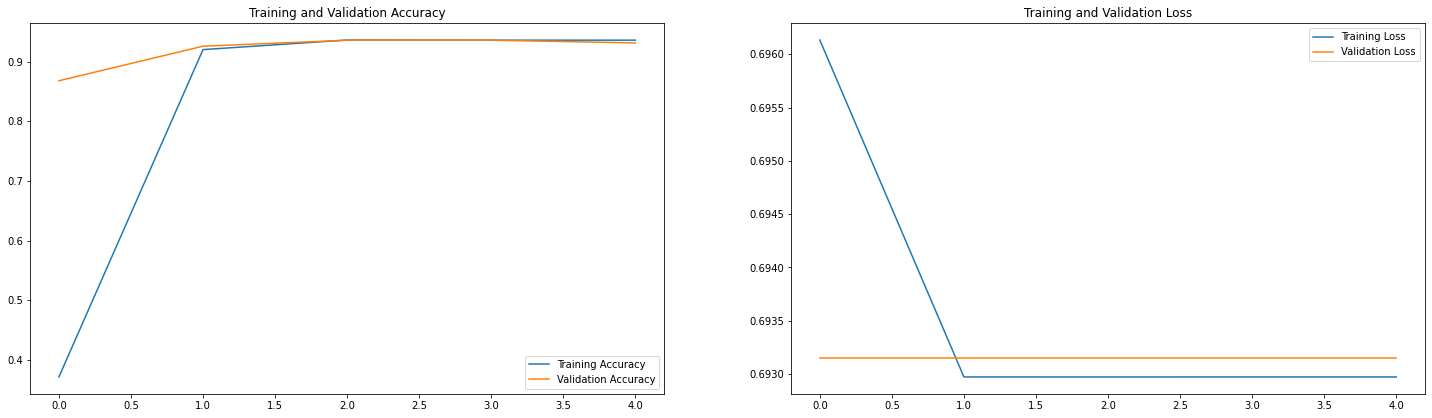

In [15]:
print(history.history)
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Actual: not blank
[[-0.91071993 -2.9393997 ]]
(1, 224, 224, 3)


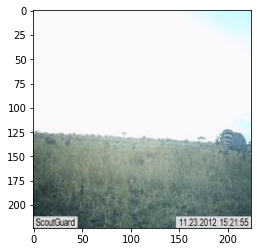

Predicted: not blank
_____________
Actual: not blank
[[-0.6964681 -2.9492798]]
(1, 224, 224, 3)


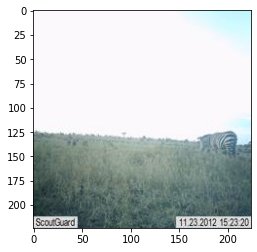

Predicted: not blank
_____________
Actual: not blank
[[-0.7991203 -2.9764752]]
(1, 224, 224, 3)


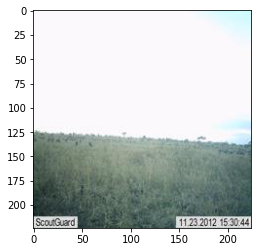

Predicted: not blank
_____________
Actual: not blank
[[-0.9381499 -3.2882888]]
(1, 224, 224, 3)


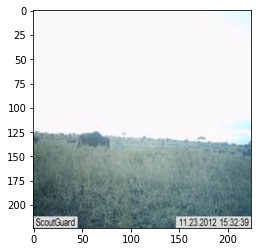

Predicted: not blank
_____________
Actual: not blank
[[-1.1091166 -2.9213521]]
(1, 224, 224, 3)


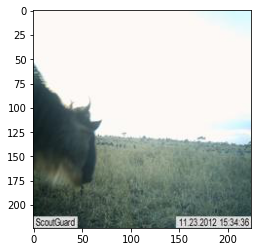

Predicted: not blank
_____________
Actual: not blank
[[-0.80150706 -3.094933  ]]
(1, 224, 224, 3)


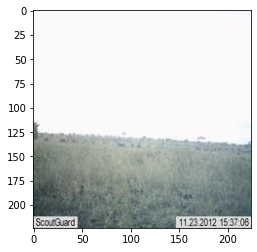

Predicted: not blank
_____________
Actual: blank
[[-2.092785  -2.9296925]]
(1, 224, 224, 3)


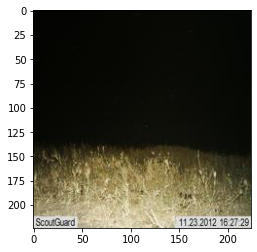

Predicted: not blank
_____________
Actual: blank
[[-2.4802742 -2.690757 ]]
(1, 224, 224, 3)


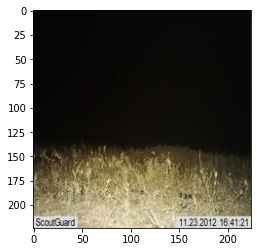

Predicted: not blank
_____________
Actual: blank
[[-2.082622 -2.91325 ]]
(1, 224, 224, 3)


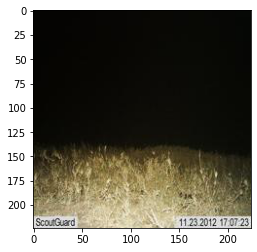

Predicted: not blank
_____________
Actual: blank
[[-2.1993878 -3.573399 ]]
(1, 224, 224, 3)


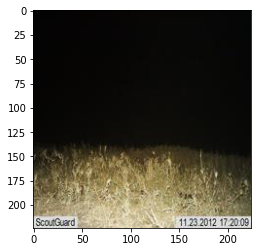

Predicted: not blank
_____________
Actual: blank
[[-2.3406897 -3.2459316]]
(1, 224, 224, 3)


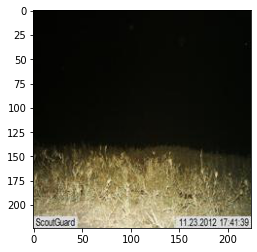

Predicted: not blank
_____________
Actual: blank
[[-2.1360435 -2.9750638]]
(1, 224, 224, 3)


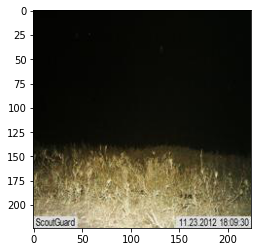

Predicted: not blank
_____________
Actual: blank
[[-2.2516696 -2.9941716]]
(1, 224, 224, 3)


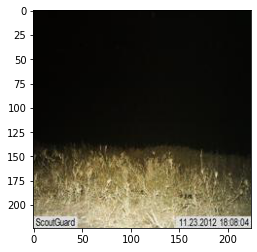

Predicted: not blank
_____________
Actual: blank
[[-2.2290647 -3.0857425]]
(1, 224, 224, 3)


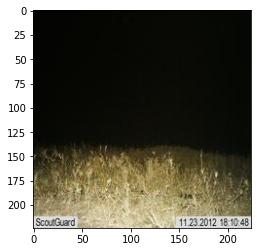

Predicted: not blank
_____________
Actual: blank
[[-1.8538053 -3.4179363]]
(1, 224, 224, 3)


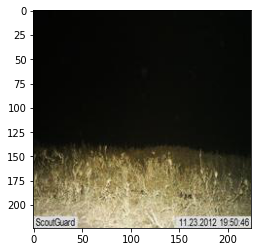

Predicted: not blank
_____________
Actual: blank
[[-2.6396184 -3.3137815]]
(1, 224, 224, 3)


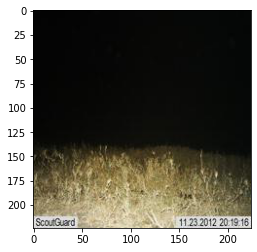

Predicted: not blank
_____________
Actual: blank
[[-2.60926   -3.0629635]]
(1, 224, 224, 3)


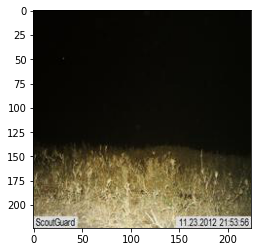

Predicted: not blank
_____________
Actual: blank
[[-2.7148747 -2.993275 ]]
(1, 224, 224, 3)


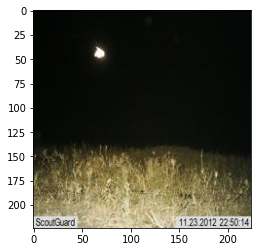

Predicted: not blank
_____________
Actual: blank
[[-0.54113865 -3.294859  ]]
(1, 224, 224, 3)


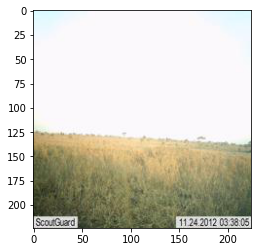

Predicted: not blank
_____________
Actual: not blank
[[-1.1833087 -3.1276655]]
(1, 224, 224, 3)


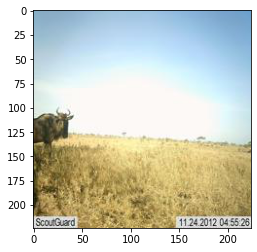

Predicted: not blank
_____________


In [17]:
for my_ind in range(10000, 10020, 1):
  labels = ["not blank", "blank"]
  X_test1 = np.empty((1, 224, 224, 3))
  X_test1[0,] = image.load_img(IMAGE_DIR+str(X_test[my_ind])+".JPG")
  print("Actual:", labels[y_test[my_ind]])

  predictions = np.array(mnv_model.predict(X_test1))
  print(predictions)
  prediction = labels[np.argmax(predictions, axis=-1)[0]]
  print(X_test1.shape)
  X_test1 = X_test1[0,]
  X_test1 = np.array(X_test1, dtype='uint8')
  plt.imshow(X_test1)
  plt.show()
  print("Predicted:", prediction)
  print("_____________")

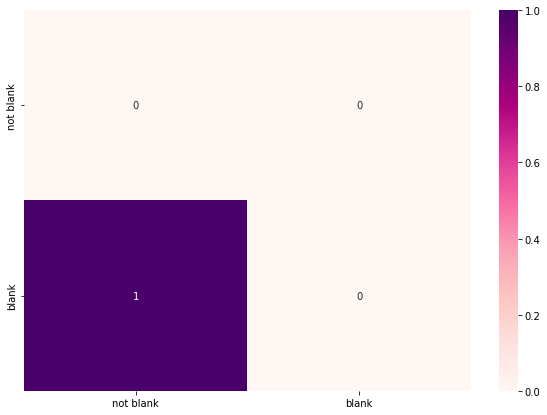

In [128]:
cm1 = confusion_matrix([y_test[0]], np.argmax(predictions, axis=1))
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx3.png',bbox_inches = 'tight')

##Evaluation

In [ ]:
img_id = "ASG0000001"
images = []
img = image.load_img("/content/drive/MyDrive/PES-Hashcode/PES-Hashcode/data/images/"+str(img_id)+".JPG")
img.show()
images.append(img)
predictions = model.predict(img)
predictions = np.argmax(predictions, axis=1)
prediction = predictions[0]
if prediction == 0:
  print("Blank Image")
else:
  print("Not Blank Image")


#Stage-2

In [31]:
labels = {}
cur_ind = 0
for val in consensus_df.Species.values:
  if val not in labels:
    labels[val] = cur_ind
    cur_ind += 1

for val in gold_df.Species.values:
  if val not in labels:
    labels[val] = cur_ind
    cur_ind += 1

rev_labels = {v:k for k,v in labels.items()}
print(labels)
print(rev_labels)

{'human': 0, 'gazelleGrants': 1, 'reedbuck': 2, 'dikDik': 3, 'zebra': 4, 'porcupine': 5, 'gazelleThomsons': 6, 'hyenaSpotted': 7, 'warthog': 8, 'impala': 9, 'elephant': 10, 'giraffe': 11, 'mongoose': 12, 'buffalo': 13, 'hartebeest': 14, 'guineaFowl': 15, 'wildebeest': 16, 'leopard': 17, 'ostrich': 18, 'lionFemale': 19, 'koriBustard': 20, 'otherBird': 21, 'batEaredFox': 22, 'bushbuck': 23, 'jackal': 24, 'cheetah': 25, 'eland': 26, 'aardwolf': 27, 'hippopotamus': 28, 'hyenaStriped': 29, 'aardvark': 30, 'hare': 31, 'baboon': 32, 'vervetMonkey': 33, 'waterbuck': 34, 'secretaryBird': 35, 'serval': 36, 'lionMale': 37, 'topi': 38, 'honeyBadger': 39, 'rodents': 40, 'wildcat': 41, 'civet': 42, 'genet': 43, 'zorilla': 44, 'caracal': 45, 'rhinoceros': 46, 'impossible': 47, 'rodent': 48}
{0: 'human', 1: 'gazelleGrants', 2: 'reedbuck', 3: 'dikDik', 4: 'zebra', 5: 'porcupine', 6: 'gazelleThomsons', 7: 'hyenaSpotted', 8: 'warthog', 9: 'impala', 10: 'elephant', 11: 'giraffe', 12: 'mongoose', 13: 'buff

In [ ]:
print("Number of Species: ", len(dict(consensus_df.Species.value_counts()).keys()))

In [47]:
# print(dict(consensus_df.Species.value_counts()))
print("Number of Species: ", len(dict(consensus_df.Species.value_counts()).keys()))
# print(dict(consensus_df.Species.value_counts()))
class_counts = dict(consensus_df.Species.value_counts())

tot = sum(list(class_counts.values()))

class_freqs = {}
for k,v in class_counts.items():
  class_freqs[k] = tot/v

tot = sum(class_freqs.values())

class_weights = {}
for k,v in class_freqs.items():
  class_weights[k] = class_freqs[k]/tot

print(class_weights)

Number of Species:  47
{'wildebeest': 4.8895134894210424e-05, 'gazelleThomsons': 5.309841098486874e-05, 'zebra': 5.8579448208215825e-05, 'buffalo': 0.00022637182397266826, 'hartebeest': 0.00027686212941173345, 'human': 0.0002928782031963576, 'elephant': 0.00030830866617693884, 'impala': 0.0003569054381129474, 'guineaFowl': 0.00040249496705457453, 'giraffe': 0.000423688872230932, 'gazelleGrants': 0.000434725630118279, 'hyenaSpotted': 0.0004701023637116287, 'warthog': 0.0005054325469630916, 'otherBird': 0.0008185161046641166, 'reedbuck': 0.0009946867894428172, 'lionFemale': 0.0011098352601418625, 'topi': 0.0012892506884623638, 'dikDik': 0.0017198210519755578, 'cheetah': 0.0021980151981346157, 'hippopotamus': 0.0022642870131537496, 'baboon': 0.002409588853570033, 'eland': 0.003230058176470223, 'lionMale': 0.004250878449222605, 'koriBustard': 0.004574549397132956, 'ostrich': 0.005034559951034594, 'jackal': 0.005270094919504049, 'serval': 0.00919577786974686, 'aardvark': 0.00969017452941067

In [158]:
consensus_df1 = consensus_df[["CaptureEventID", "Species", "Count", "Standing", "Resting", "Moving", "Eating", "Interacting", "Babies"]]
consensus_df1.loc[consensus_df1.Standing>=0.5, "Standing"] = 1
consensus_df1.loc[consensus_df1.Standing<0.5, "Standing"] = 0
consensus_df1 = consensus_df1.astype({"Standing":"int32"})

consensus_df1.loc[consensus_df1.Standing>=0.5, "Resting"] = 1
consensus_df1.loc[consensus_df1.Standing<0.5, "Resting"] = 0
consensus_df1 = consensus_df1.astype({"Resting":"int32"})

consensus_df1.loc[consensus_df1.Standing>=0.5, "Moving"] = 1
consensus_df1.loc[consensus_df1.Standing<0.5, "Moving"] = 0
consensus_df1 = consensus_df1.astype({"Moving":"int32"})

consensus_df1.loc[consensus_df1.Standing>=0.5, "Eating"] = 1
consensus_df1.loc[consensus_df1.Standing<0.5, "Eating"] = 0
consensus_df1 = consensus_df1.astype({"Eating":"int32"})

consensus_df1.loc[consensus_df1.Standing>=0.5, "Interacting"] = 1
consensus_df1.loc[consensus_df1.Standing<0.5, "Interacting"] = 0
consensus_df1 = consensus_df1.astype({"Interacting":"int32"})

consensus_df1.loc[consensus_df1.Standing>=0.5, "Babies"] = 1
consensus_df1.loc[consensus_df1.Standing<0.5, "Babies"] = 0
consensus_df1 = consensus_df1.astype({"Babies":"int32"})

consensus_df1.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,CaptureEventID,Species,Count,Standing,Resting,Moving,Eating,Interacting,Babies
0,ASG0002kjh,human,1,1,1,1,1,1,1
1,ASG0002kji,human,2,0,0,0,0,0,0
2,ASG0002kjm,gazelleGrants,1,0,0,0,0,0,0
3,ASG0002kjn,reedbuck,1,1,1,1,1,1,1
4,ASG0002kjo,dikDik,1,1,1,1,1,1,1


In [159]:
class DataGeneratorMulti(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(224,224), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = np.array(labels)
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp, indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_augmentation(self, img):
      'Apply some data augmentation'
      # img = image.random_flip_left_right(img)
      # img = image.random_flip_up_down(img)
      return img

    def __data_generation(self, list_IDs_temp, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = image.load_img(IMAGE_DIR+str(ID)+".JPG")
            # X[i,] = np.load('data/' + ID + '.npy')

            X[i,] = self.__data_augmentation(X[i,])

            # Store class
            y[i] = self.labels[:, indexes[i]]

        return X, y